In [1]:
import torch
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
from src.utils.dataset import MNISTSampler
from src.utils.flow import GaussianConditionalProbabilityPath, LinearAlpha, LinearBeta, CFGVectorFieldODE, EulerSimulator
from architecture.nn_models import IsingNet
from src.utils.trainer import CFGTrainer


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

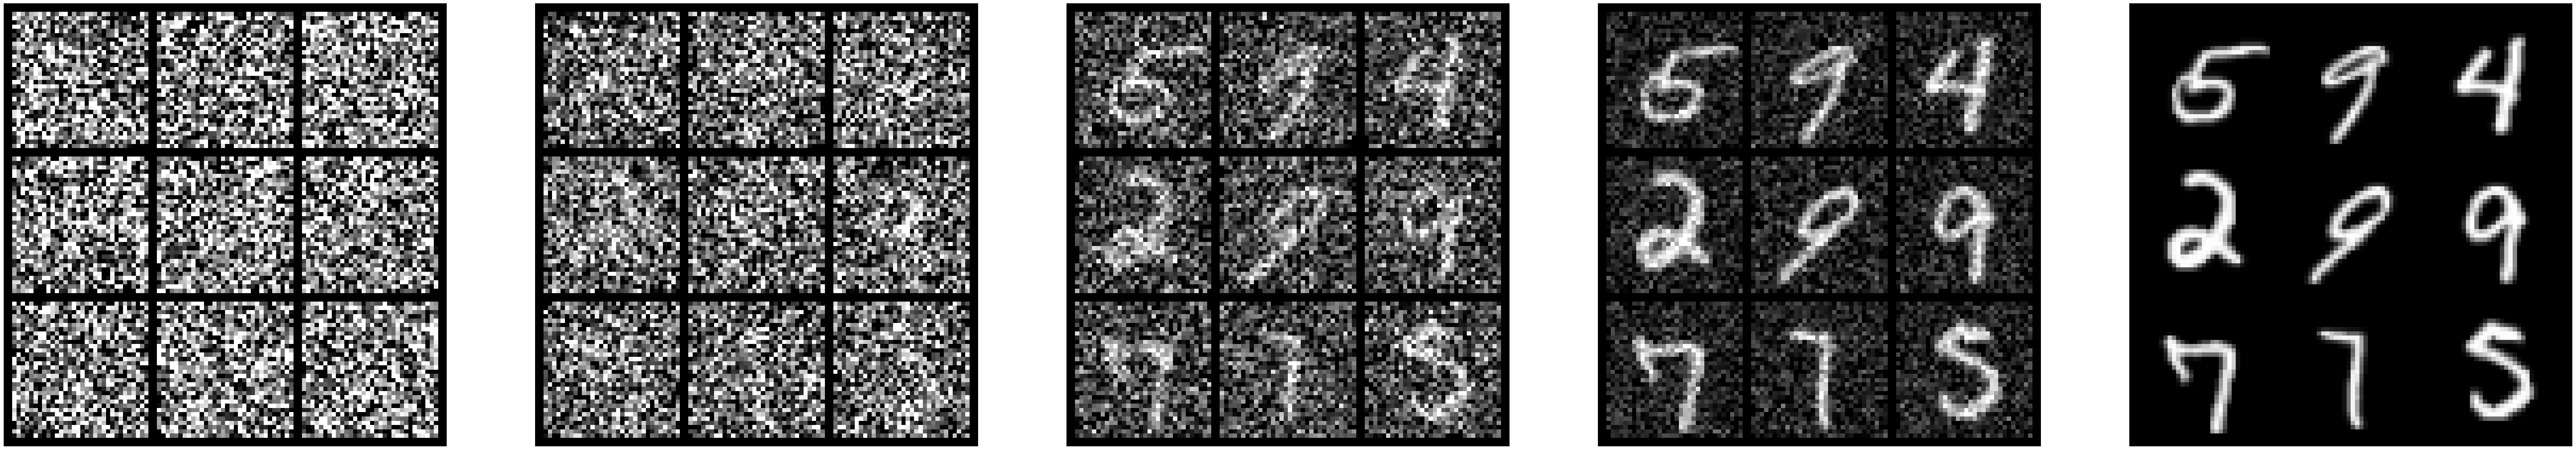

In [3]:
# Change these!
num_rows = 3
num_cols = 3
num_timesteps = 5

# Initialize our sampler
sampler = MNISTSampler().to(device)

# Initialize probability path
path = GaussianConditionalProbabilityPath(
    p_data = MNISTSampler(),
    p_simple_shape = [1, 32, 32],
    alpha = LinearAlpha(),
    beta = LinearBeta()
).to(device)

# Sample 
num_samples = num_rows * num_cols
z, _ = path.p_data.sample(num_samples)
z = z.view(-1, 1, 32, 32)

# Setup plot
fig, axes = plt.subplots(1, num_timesteps, figsize=(6 * num_cols * num_timesteps, 6 * num_rows))

# Sample from conditional probability paths and graph
ts = torch.linspace(0, 1, num_timesteps).to(device)
for tidx, t in enumerate(ts):
    tt = t.view(1,1,1,1).expand(num_samples, 1, 1, 1) # (num_samples, 1, 1, 1)
    xt = path.sample_conditional_path(z, tt) # (num_samples, 1, 32, 32)
    grid = make_grid(xt, nrow=num_cols, normalize=True, value_range=(-1,1))
    axes[tidx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
    axes[tidx].axis("off")
plt.show()

In [5]:
# Initialize probability path
path = GaussianConditionalProbabilityPath(
    p_data = MNISTSampler(),
    p_simple_shape = [1, 32, 32],
    alpha = LinearAlpha(),
    beta = LinearBeta()
).to(device)

# Initialize model
unet = IsingNet(
    channels = [32, 64, 128],
    num_residual_layers = 2,
    t_embed_dim = 40,
    y_embed_dim = 40,
)

# Initialize trainer
trainer = CFGTrainer(path = path, model = unet, eta=0.1)

In [ ]:
# Train!
loss_history = trainer.train(num_epochs = 5000, device=device, lr=1e-3, batch_size=250)

  0%|          | 0/99 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

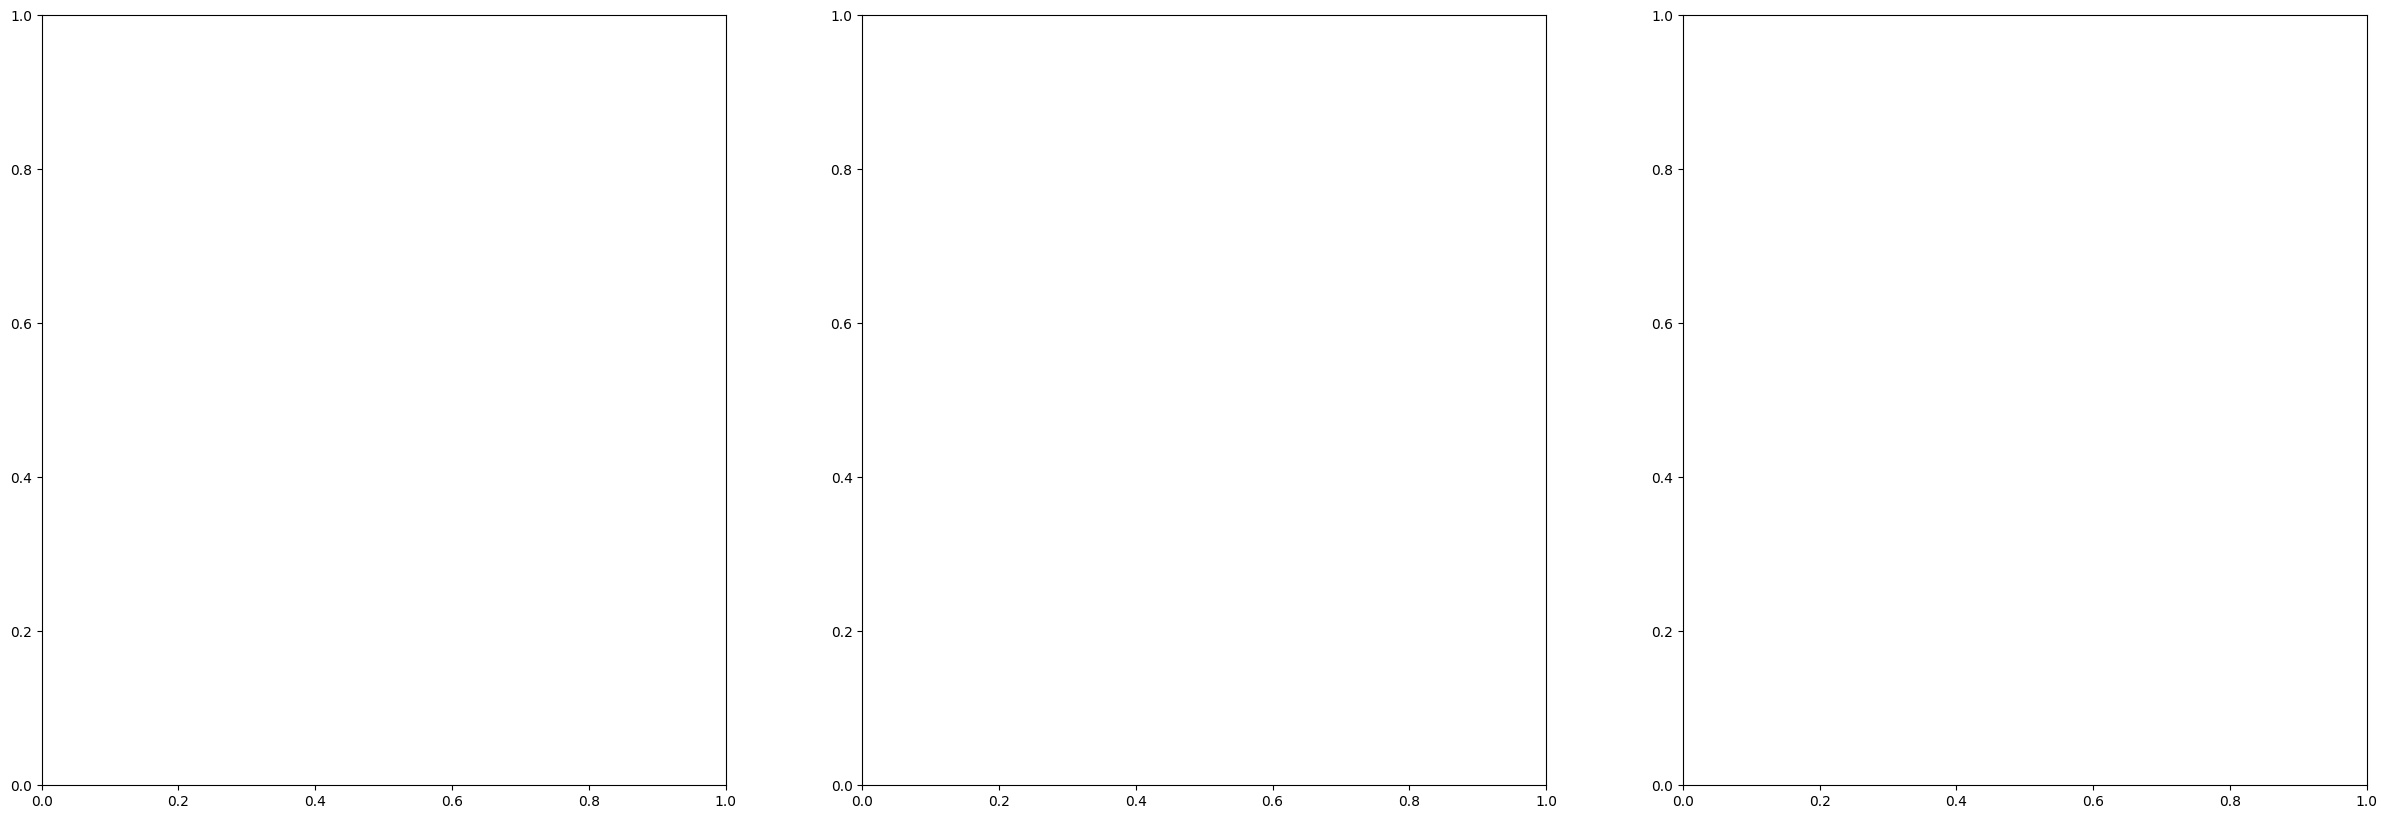

In [ ]:
# Play with these!
samples_per_class = 10
num_timesteps = 100
guidance_scales = [1.0, 3.0, 5.0]

# Graph
fig, axes = plt.subplots(1, len(guidance_scales), figsize=(10 * len(guidance_scales), 10))

for idx, w in enumerate(guidance_scales):
    simulator = EulerSimulator(CFGVectorFieldODE(net=unet, guidance_scale=w))

    # Sample initial conditions
    y = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=torch.int64).repeat_interleave(samples_per_class).to(device)
    num_samples = y.shape[0]
    x0, _ = path.p_simple.sample(num_samples) # (num_samples, 1, 32, 32)

    # Simulate
    ts = torch.linspace(0,1,num_timesteps).view(1, -1, 1, 1, 1).expand(num_samples, -1, 1, 1, 1).to(device)
    print(x0.device, ts.device, y.device)
    x1 = simulator.simulate(x0, ts, y=y)

    # Plot
    grid = make_grid(x1, nrow=samples_per_class, normalize=True, value_range=(-1,1))
    axes[idx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
    axes[idx].axis("off")
    axes[idx].set_title(f"Guidance: $w={w:.1f}$", fontsize=25)
plt.show()

In [ ]:
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss History")
plt.show()